In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pywt
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from skimage.restoration import denoise_wavelet
from scipy.signal import find_peaks, welch
from sklearn.decomposition import PCA
from scipy.ndimage import zoom
from scipy.signal import wiener
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def denoise(df):
    cutoff_freq = 50
    order = 4
    time = df['time'].iloc[-1]
    fs = len(df.time)/time
    b, a = butter(order, cutoff_freq / (fs / 2), btype='high')
    for i in range(1,df.shape[1]):
        signal = np.array(df.iloc[:,i]).astype(np.float64)
        filtered_signal = filtfilt(b, a, signal)
        x_denoise = denoise_wavelet(filtered_signal, method='BayesShrink', mode='soft', wavelet_levels=3,
                                    wavelet='sym8', rescale_sigma='True')
        df.iloc[:,i] = wiener(x_denoise)

    return None

In [ ]:
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def compute_features(signal_numeric):

    signal_numeric = signal_numeric.values
    # Compute mean value
    mean_value = np.mean(signal_numeric)

    # Compute standard deviation
    std_dev = np.std(signal_numeric)

    # Compute maximum value
    max_value = np.max(signal_numeric)

    # Compute minimum value
    min_value = np.min(signal_numeric)

    # Compute skewness
    skewness = skew(signal_numeric)

    # Compute kurtosis
    kurtosis_value = kurtosis(signal_numeric)

    # Compute median
    median_value = np.median(signal_numeric)

    # Compute line length
    line_length = np.sum(np.abs(np.diff(signal_numeric)))

    # Compute mean of vertex-to-vertex amplitudes
    vv_ampl_mean = np.mean(np.abs(np.diff(signal_numeric)))

    # Compute variance of vertex-to-vertex amplitudes
    vv_ampl_var = np.var(np.abs(np.diff(signal_numeric)))

    # Compute mean of vertex-to-vertex times
    vv_time_mean = np.mean(np.diff(signal_numeric))

    # Compute variance of vertex-to-vertex times
    vv_time_var = np.var(np.diff(signal_numeric))

    # # Compute mean of vertex-to-vertex slope
    # vv_slope_mean = np.mean(np.diff(signal_numeric) / np.diff(range(len(signal_numeric))))

    # # Compute variance of vertex-to-vertex slope
    # vv_slope_var = np.var(np.diff(signal_numeric) / np.diff(range(len(signal_numeric) - 1)))

    # Compute number of zero crossings
    zero_crossings = np.sum(np.diff(np.sign(signal_numeric)) != 0)

    # Compute amplitude range
    ampl_range = np.max(signal_numeric) - np.min(signal_numeric)

    # Calculate first derivative
    first_derivative = np.gradient(signal_numeric)

    # Calculate second derivative
    second_derivative = np.gradient(first_derivative)

    # Compute mean value of the first derivative
    first_diff_mean = np.mean(first_derivative)

    # Compute maximum value of the first derivative
    first_diff_max = np.max(first_derivative)

    # Compute mean value of the second derivative
    second_diff_mean = np.mean(second_derivative)

    # Compute maximum value of the second derivative
    second_diff_max = np.max(second_derivative)

    # Compute Hjorth Parameter 1: Activity
    hjorth_activity = np.var(signal_numeric)

    # Compute Hjorth Parameter 2: Mobility
    hjorth_mobility = np.std(first_derivative) / np.std(signal_numeric)

    # Compute Hjorth Parameter 3: Complexity
    hjorth_complexity = np.std(second_derivative) / np.std(first_derivative)

    # Compute FFT
    fft_result = np.fft.fft(signal_numeric)
    fs = 1 / 0.8  # Sampling frequency
    freqs = np.fft.fftfreq(len(fft_result), 1 / fs)  # Frequency axis

    # Define frequency bands
    delta_indices = np.where((freqs >= 0.1) & (freqs <= 3))[0]

    # Compute delta power
    delta_power = np.sum(np.abs(fft_result[delta_indices]) ** 2)

    # Create a dictionary to store the features
    features = {
        'Mean Value': mean_value,
        'Standard Deviation': std_dev,
        'Maximum Value': max_value,
        'Minimum Value': min_value,
        'Skewness': skewness,
        'Kurtosis': kurtosis_value,
        'Median': median_value,
        'Line Length': line_length,
        'Mean of Vertex-to-Vertex Amplitudes': vv_ampl_mean,
        'Variance of Vertex-to-Vertex Amplitudes': vv_ampl_var,
        'Mean of Vertex-to-Vertex Times': vv_time_mean,
        'Variance of Vertex-to-Vertex Times': vv_time_var,
        'Zero Crossings': zero_crossings,
        'Amplitude Range': ampl_range,
        'Mean of First Derivative': first_diff_mean,
        'Maximum Value of First Derivative': first_diff_max,
        'Mean of Second Derivative': second_diff_mean,
        'Maximum Value of Second Derivative': second_diff_max,
        'Hjorth Parameter Activity': hjorth_activity,
        'Hjorth Parameter Mobility': hjorth_mobility,
        'Hjorth Parameter Complexity': hjorth_complexity,
        'Delta Power': delta_power
    }

    return features

# Example usage:
# features = compute_features(win[1])


In [ ]:
import os
import pandas as pd
from scipy.signal import find_peaks
import numpy as np

# Function to apply windowing method
def apply_window(data, window_size):
    segments = []
    for i in range(0, len(data), window_size):
        segment = data[i:i+window_size]
        if len(segment) == window_size:
            segments.append(segment)
    return segments
directory = '/content/drive/MyDrive/emgdata/new_dataset'
t_data=[]
processed_data = []
data_dicts=[]
aa=[]
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):

        os.chdir(subdir_path)

        for dirs in os.listdir(subdir_path):
             label = dirs
             lak=os.path.join(subdir_path,dirs)
             print(lak)
             for lak1 in os.listdir(lak):
                  lak2=os.path.join(lak,lak1)
                  print(lak2)
                  for filename in os.listdir(lak2):
                    combined_data={}

                    info = {'label': label}
                    if filename.startswith('concatenat') and filename.endswith('.csv'):
                        filepath=os.path.join(lak2,filename)
                        df = pd.read_csv(filepath)
                        x=pd.DataFrame(df)

                        df_new=x[(x['time']>=x.iloc[1,0]+3) & (x['time']<=x.iloc[1,0]+8.5)]

                        df_new['label']=label
                        t_data.append(df_new)


In [ ]:
len(t_data)

196

In [ ]:
import numpy as np
import pandas as pd
win = []
def sliding_window(ffa, window_size=250):

    signal = ffa
    signal['time_ms'] = signal['time'] * 1000
    samples_per_window = int(window_size / (signal['time_ms'].iloc[1] - signal['time_ms'].iloc[0]))
    wina=[]
    for i in range(0, len(signal) - samples_per_window + 1, samples_per_window):

        window_data = signal.iloc[i:i+samples_per_window, :]

        wina.append(window_data)
    win.append(wina)



# Call the function with ffa as input


In [ ]:
for obj in t_data:
    sliding_window(obj)



# Check the length of the list of windows
print(len(win))

196


<ipython-input-30-b7d5855c100f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal['time_ms'] = signal['time'] * 1000


In [ ]:
win[0][0]

,time,Brachiarod,EXt Carp,EXT DIG,Flex CarpU,Flex Carp R,label,time_ms
6001,46.9805,-2.128277,-7.561226,-5.475044,1.872347,-5.184949,Pointing,46980.5
6002,46.9810,0.923667,-4.204087,-6.390628,3.093125,-1.522617,Pointing,46981.0
6003,46.9815,0.923667,-4.509282,-11.884127,1.261958,0.308550,Pointing,46981.5
6004,46.9820,0.008084,-5.119671,-16.462043,0.651569,-1.522617,Pointing,46982.0
6005,46.9825,2.144444,-3.288504,-17.072432,4.924291,-4.269366,Pointing,46982.5
...,...,...,...,...,...,...,...,...
6496,47.2280,11.605471,3.730967,-12.189321,4.313902,3.055300,Pointing,47228.0
6497,47.2285,12.826249,4.036162,-12.189321,7.060652,3.360494,Pointing,47228.5
6498,47.2290,14.352221,4.646551,-11.273738,9.502207,3.055300,Pointing,47229.0
6499,47.2295,13.436638,5.256939,-13.715293,8.891818,3.360494,Pointing,47229.5


In [ ]:
win_futures=[]

In [ ]:
import pandas as pd

def process_win(win):
    # Create an empty DataFrame to store the computed features
    features_df = pd.DataFrame()
    division_values = win['label'].drop_duplicates()

    ii = win.drop(columns=['time', 'label',  'time_ms'])

    # Convert signal DataFrame to numeric values
    ii = ii.apply(pd.to_numeric, errors='coerce')
    ii.dropna(inplace=True)  # Drop rows with NaN values

    # Iterate over each column in the DataFrame
    for col in ii.columns:
        # Compute features for the current column
        col_features = compute_features(ii[col])

        # Add the computed features as a new column in the features DataFrame
        features_df[col] = col_features

    # Concatenate the computed features DataFrame with one_row_df
    one_row_df = pd.concat([features_df[col] for col in features_df.columns], axis=0).to_frame().T
    # one_row_df['label'] = division_values.iloc[0]

    # Append one_row_df to existing_df
    # win_futures.append(one_row_df)
    return one_row_df,division_values.iloc[0]



# Call the function with win as input



In [ ]:
for i in win:
  lab=[]
  onerows=[]

  for obj in i:

    onerow_df,lable= process_win(obj)

    lab.append(lable)
    onerows.append(onerow_df)
  if len(np.unique(np.array(lab))):
    concatenated_array = np.concatenate(onerows, axis=1)

    # Convert to DataFrame
    onerows_df_one = pd.DataFrame(concatenated_array)

    # Transpose the DataFrame and reset index to make it a single row
    # aa_single_row_df = onerows_df_one.T.iloc[:, 0].reset_index(drop=True)
    # aa_single_row_df = pd.DataFrame(concatenated_array)
    print(np.unique(np.array(lab)))
    onerows_df_one['labela'] = np.unique(np.array(lab))
    win_futures.append(onerows_df_one)




In [ ]:
len(win_futures)

196

In [ ]:
win_futures[0]

,0,1,2,3,4,5,6,7,8,9,...,2411,2412,2413,2414,2415,2416,2417,2418,2419,labela
0,0.453667,12.384864,45.48205,-65.913908,-0.591223,3.122044,0.465875,2384.483907,4.778525,19.833134,...,324.116461,0.086675,56.613563,-0.060428,44.024293,1239.418594,0.413947,0.636427,3.092879e+07,Pointing


In [ ]:
len(win[0])

22

In [ ]:
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def compute_features(signal_numeric):

    signal_numeric = signal_numeric.values

    mean_value = np.mean(signal_numeric)

    std_dev = np.std(signal_numeric)

    max_value = np.max(signal_numeric)

    min_value = np.min(signal_numeric)

    skewness = skew(signal_numeric)

    kurtosis_value = kurtosis(signal_numeric)

    median_value = np.median(signal_numeric)

    line_length = np.sum(np.abs(np.diff(signal_numeric)))

    vv_ampl_mean = np.mean(np.abs(np.diff(signal_numeric)))

    vv_ampl_var = np.var(np.abs(np.diff(signal_numeric)))

    vv_time_mean = np.mean(np.diff(signal_numeric))

    vv_time_var = np.var(np.diff(signal_numeric))

    zero_crossings = np.sum(np.diff(np.sign(signal_numeric)) != 0)

    ampl_range = np.max(signal_numeric) - np.min(signal_numeric)

    first_derivative = np.gradient(signal_numeric)

    second_derivative = np.gradient(first_derivative)


    first_diff_mean = np.mean(first_derivative)

    first_diff_max = np.max(first_derivative)

    second_diff_mean = np.mean(second_derivative)

    second_diff_max = np.max(second_derivative)

    hjorth_activity = np.var(signal_numeric)

    hjorth_mobility = np.std(first_derivative) / np.std(signal_numeric)

    hjorth_complexity = np.std(second_derivative) / np.std(first_derivative)

    fft_result = np.fft.fft(signal_numeric)
    fs = 1 / 0.8
    freqs = np.fft.fftfreq(len(fft_result), 1 / fs)  # Frequency axis

    delta_indices = np.where((freqs >= 0.1) & (freqs <= 3))[0]

    delta_power = np.sum(np.abs(fft_result[delta_indices]) ** 2)

    features = {
        'Mean Value': mean_value,
        'Standard Deviation': std_dev,
        'Maximum Value': max_value,
        'Minimum Value': min_value,
        'Skewness': skewness,
        'Kurtosis': kurtosis_value,
        'Median': median_value,
        'Line Length': line_length,
        'Mean of Vertex-to-Vertex Amplitudes': vv_ampl_mean,
        'Variance of Vertex-to-Vertex Amplitudes': vv_ampl_var,
        'Mean of Vertex-to-Vertex Times': vv_time_mean,
        'Variance of Vertex-to-Vertex Times': vv_time_var,
        'Zero Crossings': zero_crossings,
        'Amplitude Range': ampl_range,
        'Mean of First Derivative': first_diff_mean,
        'Maximum Value of First Derivative': first_diff_max,
        'Mean of Second Derivative': second_diff_mean,
        'Maximum Value of Second Derivative': second_diff_max,
        'Hjorth Parameter Activity': hjorth_activity,
        'Hjorth Parameter Mobility': hjorth_mobility,
        'Hjorth Parameter Complexity': hjorth_complexity,
        'Delta Power': delta_power
    }

    return features

# Example usage:
# features = compute_features(win[1])


In [ ]:
import os
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import numpy as np
import pandas as pd


def apply_window(data, window_size,samples_per_window):
    segments=[]
    for i in range(0, len(data) - samples_per_window + 1, samples_per_window):

        window_data = data[i:i+samples_per_window]

        segments.append(window_data)
    return segments


directory = r'/content/drive/MyDrive/emgdata/new_dataset'

processed_data = []
data_dicts=[]
aa=[]
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):

        os.chdir(subdir_path)

        for dirs in os.listdir(subdir_path):
             label = dirs
             lak=os.path.join(subdir_path,dirs)
             print(lak)
             for lak1 in os.listdir(lak):
                  lak2=os.path.join(lak,lak1)

                  for filename in os.listdir(lak2):
                    combined_data={}

                    info = {'label': label}
                    if filename.startswith('concatenat') and filename.endswith('.csv'):
                        filepath=os.path.join(lak2,filename)
                        df = pd.read_csv(filepath)

                        df['time'] = df['time'] - df['time'][0]

                        df = df[(df['time'] >= 3) & (df['time'] <= 8.5)]

                        window_size = 250
                        data_dict={}
                        samples_per_window=int(window_size/((df['time'].iloc[1]-df['time'].iloc[0])*1000))
                        for column in df.columns:
                            if column != 'time':
                                segments = apply_window(df[column], window_size,samples_per_window)
                                la={}
                                i1=0
                                print(len(segments))
                                for segment in segments:
                                    features = compute_features(segment)
                                    features = pd.Series(compute_features(segment)).values
                                    for i, feature in enumerate(features):
                                        data_dict[f'channel_{column}_window_{i1+1}_feature_{i}'] = feature
                                    i1=i1+1
                        data_dict.update(info)
                        data_dicts.append(data_dict)
result_df = pd.concat([pd.DataFrame([d]) for d in data_dicts], ignore_index=True)


In [ ]:
result_df.shape

(196, 2421)

In [ ]:
result_df

,channel_Brachiarod_window_1_feature_0,channel_Brachiarod_window_1_feature_1,channel_Brachiarod_window_1_feature_2,channel_Brachiarod_window_1_feature_3,channel_Brachiarod_window_1_feature_4,channel_Brachiarod_window_1_feature_5,channel_Brachiarod_window_1_feature_6,channel_Brachiarod_window_1_feature_7,channel_Brachiarod_window_1_feature_8,channel_Brachiarod_window_1_feature_9,...,channel_Flex Carp R_window_22_feature_13,channel_Flex Carp R_window_22_feature_14,channel_Flex Carp R_window_22_feature_15,channel_Flex Carp R_window_22_feature_16,channel_Flex Carp R_window_22_feature_17,channel_Flex Carp R_window_22_feature_18,channel_Flex Carp R_window_22_feature_19,channel_Flex Carp R_window_22_feature_20,channel_Flex Carp R_window_22_feature_21,label
0,0.401350,12.385445,45.482050,-65.913908,-0.582590,3.120970,0.313278,2381.126769,4.781379,19.829991,...,324.116461,0.081650,56.613563,-0.040061,44.024293,1265.588674,0.418754,0.635408,3.150080e+07,Pointing
1,0.050285,13.968053,39.683357,-50.043799,-0.730653,1.493747,1.839250,2454.373427,4.928461,22.246178,...,187.999755,0.036085,51.272660,0.041131,34.105475,701.302188,0.434681,0.680360,2.389805e+07,Pointing
2,-0.086716,11.012545,30.222330,-48.212633,-0.745752,2.725026,0.008084,1854.361221,3.723617,14.237867,...,210.584141,0.087461,43.947995,-0.049846,40.896051,1252.893109,0.460628,0.702402,4.376717e+07,Pointing
3,-0.104228,13.283541,34.189857,-48.823022,-0.733811,1.268053,0.923667,2241.958119,4.492902,17.486788,...,397.057925,0.019838,73.551852,0.130165,48.831105,3828.377480,0.377919,0.646992,9.671805e+07,Pointing
4,-0.082435,13.150719,47.618411,-39.361995,-0.284379,0.939306,0.618472,2394.555323,4.808344,19.308059,...,356.467068,-0.008868,66.532381,-0.095717,62.107062,2582.969770,0.351292,0.622619,5.642160e+07,Pointing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.183260,6.777189,23.824229,-28.058820,-0.341102,1.316201,0.019065,1557.712257,3.121668,6.964671,...,334.798265,0.214246,108.649209,-0.064243,65.998291,3034.975838,0.499517,0.699100,1.584788e+08,Wave in
192,0.230071,6.171985,24.129423,-19.208183,0.190983,0.749187,0.019065,1008.667517,2.025437,3.584948,...,347.311236,-0.027217,125.740096,-0.036085,81.486907,3557.141363,0.491360,0.706096,1.772589e+08,Wave in
193,-0.050519,5.862752,17.720341,-15.240655,-0.102606,-0.131405,0.629454,966.245495,1.936364,2.676099,...,284.135993,-0.092169,82.707685,-0.000153,57.223951,1280.025322,0.532746,0.751866,6.740579e+07,Wave in
194,0.080226,6.665588,23.824229,-15.240655,0.409394,0.521666,0.019065,998.901296,2.005826,3.018732,...,368.674845,-0.204584,126.350485,-0.037308,100.408960,2733.974201,0.596584,0.759091,2.114971e+08,Wave in


In [ ]:
result_df.to_csv('/content/drive/MyDrive/window_250_22features.csv')

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/window_250_22features.csv')
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy: 0.825
F1 Score: 0.8202516233766234


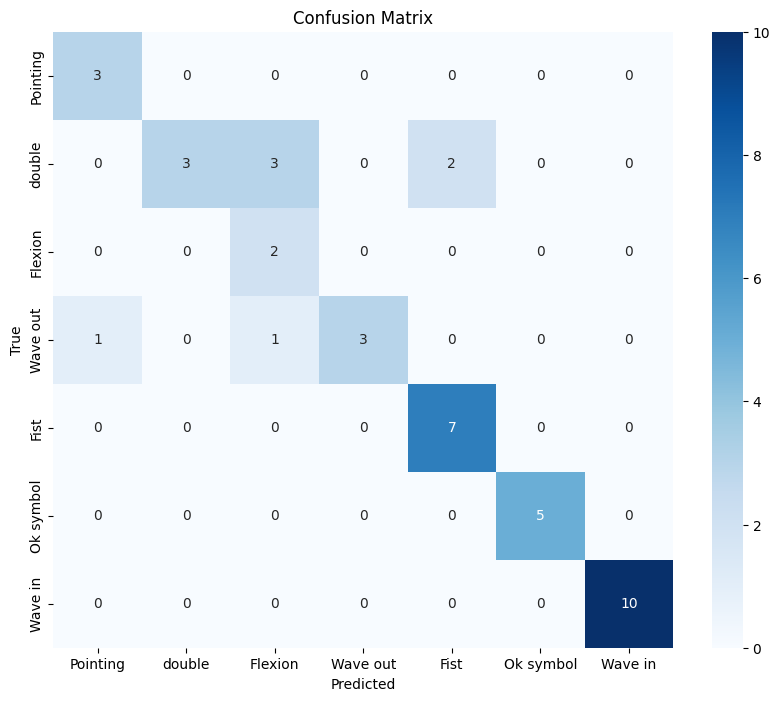

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)


y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Support Vector Classifier (SVC) - Best parameters: {'C': 10, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Support Vector Classifier (SVC) - Best mean cross-validated accuracy: 0.8713709677419356
Best SVC Model - Accuracy: 0.85
Best SVC Model - F1 Score: 0.8414841694253459


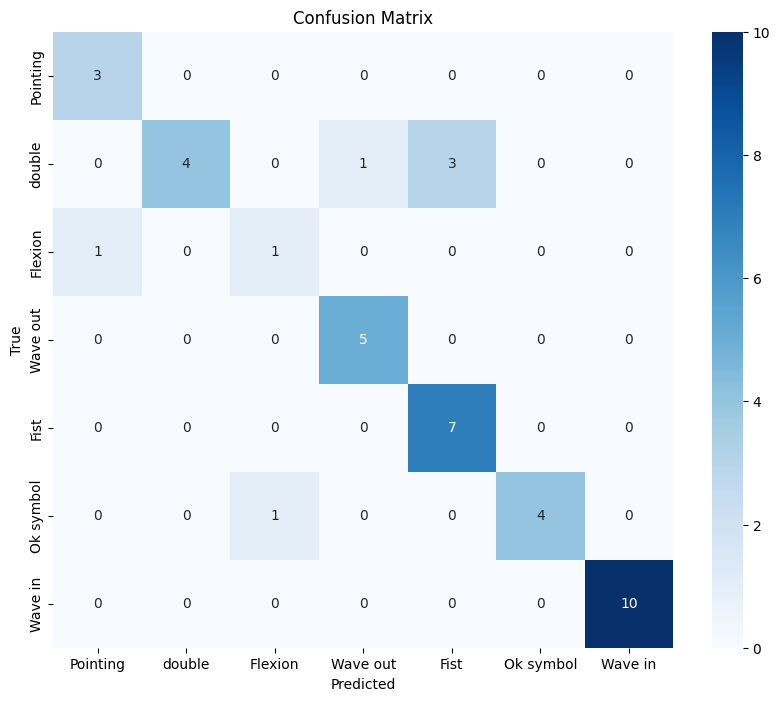

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf','poly'],   'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5]
}

svc = SVC()

# Perform GridSearchCV for SVC
svc_grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
svc_grid_search.fit(X_train_scaled, y_train)

print("Support Vector Classifier (SVC) - Best parameters:", svc_grid_search.best_params_)
print("Support Vector Classifier (SVC) - Best mean cross-validated accuracy:", svc_grid_search.best_score_)

# Evaluate the best SVC model on the test set
best_svc = svc_grid_search.best_estimator_
y_pred = best_svc.predict(X_test_scaled)

# Calculate accuracy_score and f1_score for the best SVC model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best SVC Model - Accuracy:", accuracy)
print("Best SVC Model - F1 Score:", f1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Cat boost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train, y_train)

# Step 6: Evaluate Model
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_preda)
print("Accuracy:", accuracy_cat)

Learning rate set to 0.071973
0:	learn: 1.9168584	total: 4.37s	remaining: 1h 12m 41s
1:	learn: 1.8799566	total: 6.15s	remaining: 51m 9s
2:	learn: 1.8447914	total: 7.85s	remaining: 43m 30s
3:	learn: 1.8131712	total: 11.3s	remaining: 46m 43s
4:	learn: 1.7736165	total: 13.9s	remaining: 46m 11s
5:	learn: 1.7397917	total: 16.4s	remaining: 45m 17s
6:	learn: 1.6949093	total: 18.6s	remaining: 43m 57s
7:	learn: 1.6679072	total: 21.3s	remaining: 43m 56s
8:	learn: 1.6448027	total: 24.6s	remaining: 45m 5s
9:	learn: 1.6226038	total: 29.4s	remaining: 48m 31s
10:	learn: 1.5964304	total: 33.2s	remaining: 49m 49s
11:	learn: 1.5780569	total: 35.3s	remaining: 48m 29s
12:	learn: 1.5523741	total: 37.1s	remaining: 46m 56s
13:	learn: 1.5288644	total: 42.1s	remaining: 49m 24s
14:	learn: 1.5036394	total: 47.1s	remaining: 51m 33s
15:	learn: 1.4844917	total: 51.8s	remaining: 53m 4s
16:	learn: 1.4619901	total: 58.7s	remaining: 56m 35s
17:	learn: 1.4396222	total: 1m 3s	remaining: 57m 19s
18:	learn: 1.4206652	total

NameError: name 'accuracy_score' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_cat)
print("Confusion Matrix:")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
cm_display.plot()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_preda)
print("Classification Report:")
print(class_report)

### XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xg = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xg)
print("Accuracy:", accuracy)

In [ ]:

conf_matrix = confusion_matrix(y_test, y_predaa)
print("Confusion Matrix:")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
cm_display.plot()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

class_report = classification_report(y_test, y_predaa)
print("Classification Report:")
print(class_report)
